In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

import matplotlib.patches as patches

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:

#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '\\'.join(parent_path.split('\\')[:-1]) 


#Check if path exists
path_common_scripts = os.path.join(path_common,'Phases','Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Phases','Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']




#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
BATCH_SIZE_TR = experiment_params['training_batch_size']
BATCH_SIZE_TE = experiment_params['testing_batch_size']
BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']


# Folder description to distinguish between experiment runs
desc = "ntr="+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_btr="+str(BATCH_SIZE_TR)
desc = desc +"_bte="+str(BATCH_SIZE_TE)
desc = desc +"_bge="+str(BATCH_SIZE_GE)
desc = desc +"_ful_l_n="+str(FUL_LAYER_NUMBER)
desc = desc +"_ful_l_s="+str(FUL_LATENT_SIZE)
desc = desc +"_ind_l_n="+str(IND_LAYER_NUMBER)
desc = desc +"_ind_l_s="+str(IND_LATENT_SIZE)
desc = desc +"_date="+str(current_time)

#Set seed
SEED = 5
desc = desc +"seed="+str(SEED)

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

Current_date: 2021-04-08 23:21:57.179601


In [3]:
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)

    
#Path to Datasets
path_dataset=os.path.abspath('..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")

In [4]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import rollout plot
from RolloutPlot import rollout_plot, rollout_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session, rollout_loss_mean, rollout_loss_max, rollout_error
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

In [5]:
vel_acc_list = ['-1.0-100.0', 
                '-1.0-1000.0',
                '-1.0-1500.0',
                '-1.0-200.0',
                '-1.0-2000.0', 
                '-1.0-2500.0', 
                '-1.0-500.0', 
                '-1.0-750.0',
                '10.0-0.0',
                '100.0-0.0', 
                '150.0-0.0',
                '20.0-0.0',
                '200.0-0.0',
                '300.0-0.0', 
                '400.0-0.0', 
                '50.0-0.0', 
                '500.0-0.0', 
                '75.0-0.0']


vel_list = ["o_t_r_x_v", 
                "o_t_r_y_v",
                "o_t_l_x_v",
                "o_t_l_y_v",
                "o_b_r_x_v",
                "o_b_r_y_v",
                "o_b_l_x_v",
                "o_b_l_y_v",
                "o_m_m_x_v",
                "o_m_m_y_v"]


vel_list_2 = ["o_t_r_x_v", 
                "o_t_r_y_v",
                "o_t_l_x_v",
                "o_t_l_y_v",
                "o_b_r_x_v",
                "o_b_r_y_v",
                "o_b_l_x_v",
                "o_b_l_y_v"]

pos_list = ["o_t_r_x", 
                "o_t_r_y",
                "o_t_l_x",
                "o_t_l_y",
                "o_b_r_x",
                "o_b_r_y",
                "o_b_l_x",
                "o_b_l_y",
                "o_m_m_x",
                "o_m_m_y",
                "e_pos_x",
                "e_pos_y"]

In [13]:
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data10ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data10ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)
# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)
_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.25)
# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2, 0.001)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2, 0.001)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2, 0.001)


df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Plotting Distributions

In [14]:
tr_np = df_tr_1[vel_list].to_numpy()

In [15]:
tr_np_re = tr_np.reshape((tr_np.shape[0],5,2))

In [16]:
tr_speed = np.linalg.norm(tr_np_re,axis=2)
tr_avg_speed = np.mean(tr_speed,axis=1)


tr_vel_mag_mean = np.mean(tr_speed)
tr_vel_mag_std = np.std(tr_speed)

In [17]:
tr_s_m = np.mean(tr_vel_mag_mean)
tr_s_s = np.mean(tr_vel_mag_std)

<IPython.core.display.Javascript object>


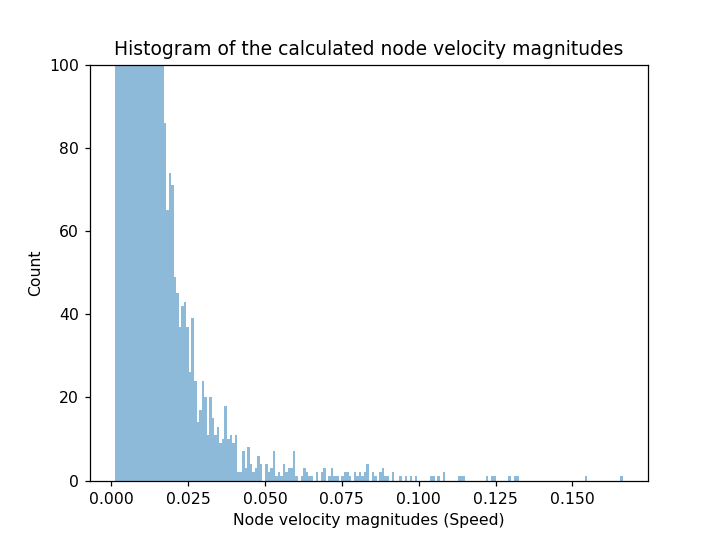

In [20]:
plt.close('all')
plt.hist(tr_avg_speed,
         bins=200, 
         alpha=0.5) 
plt.text(0, 120000,  f"\u03BC={tr_s_m}\n\u03C3={tr_s_s}")
# set title and labels
plt.xlabel("Node velocity magnitudes (Speed)")
plt.ylabel("Count") 
plt.title("Histogram of the calculated node velocity magnitudes")  
plt.ylim([0, 100]) 
plt.show()

In [20]:
tr_np_re = tr_np.reshape((tr_np.shape[0],5,2))

tr_np_re_x = tr_np_re[:,:,0]
tr_np_re_x = tr_np_re_x.reshape((tr_np_re_x.shape[0]*5))
tr_np_re_y = tr_np_re[:,:,1]
tr_np_re_y = tr_np_re_y.reshape((tr_np_re_y.shape[0]*5))


tr_v_x_mean = np.mean(tr_np_re_x)
tr_v_y_mean = np.mean(tr_np_re_y)

tr_v_x_std = np.std(tr_np_re_x)
tr_v_y_std = np.std(tr_np_re_y)

<IPython.core.display.Javascript object>


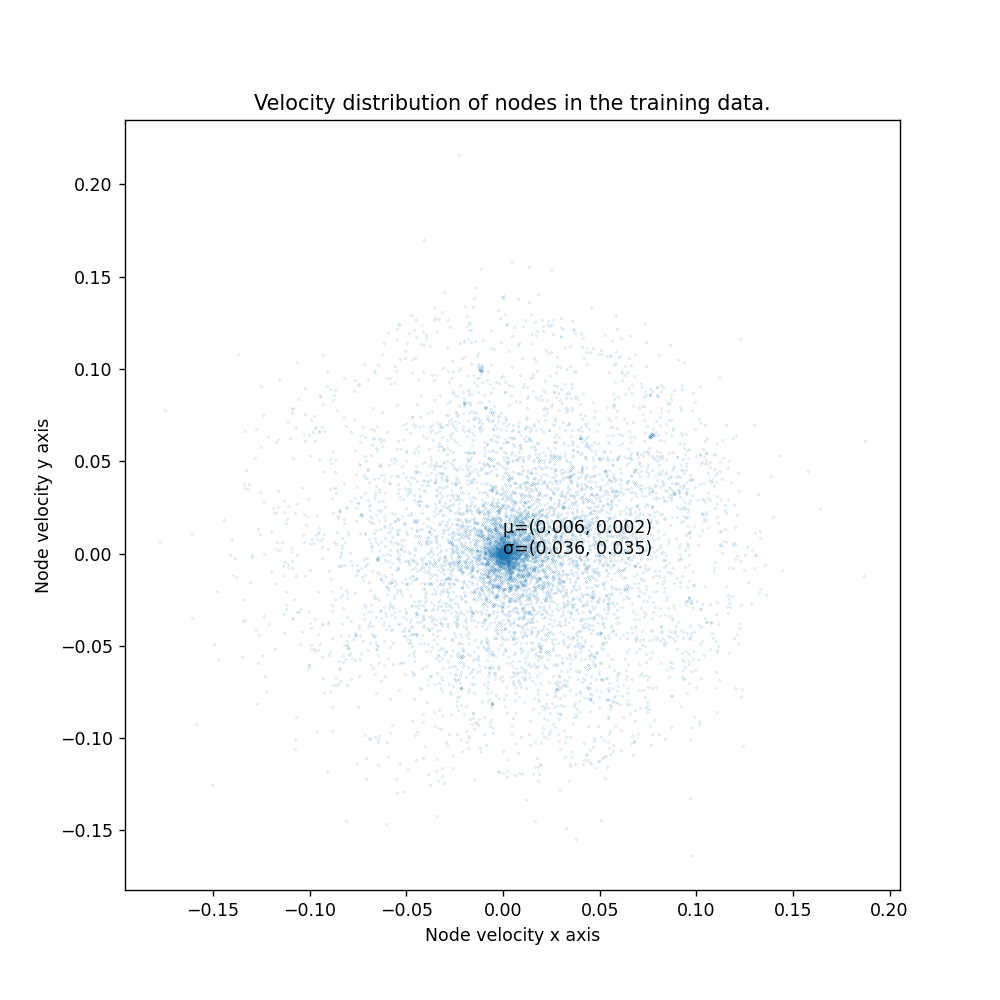

In [23]:
plt.close('all')
plt.figure(figsize=(8,8))

plt.scatter(tr_np_re_x, tr_np_re_y, marker='o', s=0.01)
#circle1 = patches.Ellipse((tr_v_x_mean, tr_v_y_mean), tr_v_x_std*2, tr_v_y_std*2, color='r', alpha=0.10)
#circle2 = patches.Ellipse((tr_v_x_mean, tr_v_y_mean), tr_v_x_std*2*2, tr_v_y_std*2*2, color='r', alpha=0.5)
#circle3 = patches.Ellipse((tr_v_x_mean, tr_v_y_mean), tr_v_x_std*2*3, tr_v_y_std*2*3, color='r', alpha=0.2)
#plt.gca().add_patch(circle1)
#plt.gca().add_patch(circle2)
#plt.gca().add_patch(circle3)
plt.xlabel("Node velocity x axis") 
plt.ylabel("Node velocity y axis") 
plt.text(0, 0,  f"\u03BC=({np.round(tr_v_x_mean,3)}, {np.round(tr_v_y_mean,3)})\n\u03C3=({np.round(tr_v_x_std,3)}, {np.round(tr_v_y_std,3)})")
plt.title("Velocity distribution of nodes in the training data.")

#plt.xlim([0.1, 0.6]) 
#plt.ylim([-0.3, 0.3]) 

plt.show()

In [ ]:
df_tr_1[]